## Preliminaries
Import required Python packages.
We will use sklearn, a popular machine learning library to build a prediction model.

In [1]:
import os
import logging
import pandas as pd
import sklearn
# check correlation
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# for plotting result
import matplotlib.pyplot as plt
# for pretty formatting of results
from tabulate import tabulate
# random forest classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from settings import Config

def random_forest_classifier(features, target):
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

def split_dataset(dataset, train_percentage, feature_headers, target_header):
    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y



no postgres instance


## Load the Open Targets data
We load the Open Targets scores for the association between genes and diseases.

We also load the gene features that we will encode as integer to build the prediction model.

In [2]:
# load ChEMBL data
HOME_DIR = os.environ['HOME']
output_datatype_scores=os.path.join(os.path.sep, HOME_DIR, 'gene_disease_associations_datatypes_with_expression.csv')
df = pd.read_csv(output_datatype_scores)
print(len(df))

# load gene info
gene_info=os.path.join(os.path.sep, HOME_DIR, 'gene_info_qtq.csv')
gene_df = pd.read_csv(gene_info)


2304670


## First look at the data
In the following, we look at the top five rows and summary statistics for the Open Targets dataset.
The first column of the data frame is the key for the association between a gene and a disease. 


In [3]:
# View the top 5 rows
df.head()

,key,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,genetic_association,somatic_mutation,known_drug,rna_expression,affected_pathway,animal_model,literature,tissue_label,source,max_fold_change,expression_score
0,ENSG00000167113-Orphanet_183616,51117.0,ENSG00000167113,COQ4,Orphanet_183616,Genetic neuro-ophthalmological disease,eye disease; genetic disorder,False,1.000000,1.000000,0.0,0.0,0.0,0.0,0.00000,Unspecified,Unspecified,0.0,0.0
1,ENSG00000173085-EFO_0000249,27235.0,ENSG00000173085,COQ2,EFO_0000249,Alzheimers disease,nervous system disease,True,0.014184,0.000000,0.0,0.0,0.0,0.0,0.00000,Unspecified,Unspecified,0.0,0.0
2,ENSG00000198612-EFO_0004512,10920.0,ENSG00000198612,COPS8,EFO_0004512,bone measurement,measurement,False,0.024117,0.024117,0.0,0.0,0.0,0.0,0.00000,Unspecified,Unspecified,0.0,0.0
3,ENSG00000181789-Orphanet_101987,22820.0,ENSG00000181789,COPG1,Orphanet_101987,Constitutional neutropenia,immune system disease; genetic disorder,False,0.144740,0.000000,0.0,0.0,0.0,0.0,0.14474,Unspecified,Unspecified,0.0,0.0
4,ENSG00000119723-Orphanet_50,51004.0,ENSG00000119723,COQ6,Orphanet_50,Aicardi syndrome,eye disease; genetic disorder,True,0.115500,0.000000,0.0,0.0,0.0,0.0,0.11550,Unspecified,Unspecified,0.0,0.0


In [4]:
# look at the daa (statistics)
print df.describe()

          entrez_id  genetic_association  somatic_mutation    known_drug  \
count  2.274296e+06         2.304670e+06      2.304670e+06  2.304670e+06   
mean   3.329095e+05         1.757477e-01      6.405781e-02  1.879467e-02   
std    5.438774e+06         2.931799e-01      2.405700e-01  1.068896e-01   
min    1.000000e+00         1.420000e-08      0.000000e+00  0.000000e+00   
25%    2.957000e+03         1.623600e-02      0.000000e+00  0.000000e+00   
50%    6.926000e+03         4.430408e-02      0.000000e+00  0.000000e+00   
75%    5.105300e+04         1.830850e-01      0.000000e+00  0.000000e+00   
max    1.097035e+08         1.557799e+00      1.494100e+00  1.273360e+00   

       rna_expression  affected_pathway  animal_model    literature  \
count    2.304670e+06      2.304670e+06  2.304670e+06  2.304670e+06   
mean     2.510575e-02      2.497605e-04  2.650752e-02  2.955334e-02   
std      1.409206e-01      2.181420e-03  1.279416e-01  6.667824e-02   
min      0.000000e+00      0.00

## Filter the data
We then filter the data to exclude any association that were propagated based on the disease classification.

We will predict the variable y which is a simple transformation of the known_drug score.

In [5]:
# get the data where is_direct is true and where there is some DRUG information
cond1 = (df['known_drug'] > 0.0) & (df['is_direct']) 
df_chembl = df[cond1]

# The predicted variable y is an integer representation of the know_drug score
df_chembl = df_chembl.assign(y=df['known_drug'].apply(lambda x: int(x*10)))


44974


## Add gene features

In [6]:
# check a few entries with some GO 
gene_df.fillna({'target_class':'Unspecified', 'locus_group':'Unspecified'}, inplace=True)
gene_df[gene_df['go_id'].notnull() & gene_df['GTEX_median_all_tissues'] > 0.0].head()

,Unnamed: 0,symbol,hgnc_id,ensembl_gene_id,entrez_id,uniprot_id,locus_type,locus_group,go_id,go_label,evidence_type,reported_count,protein_class,target_class,topology_type,target_location,ExAC_LoF,pc_mouse_gene_identity,GTEX_median_all_tissues,description
60,60,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0006968,cellular defense response,TAS,1.0,NaN,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
61,61,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0046961,"proton-transporting ATPase activity, rotationa...",IBA,1.0,NaN,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
62,62,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0016236,macroautophagy,ISS,1.0,NaN,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
63,63,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0101003,ficolin-1-rich granule membrane,TAS,1.0,NaN,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
64,64,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0000220,"vacuolar proton-transporting V-type ATPase, V0...",IEA,1.0,NaN,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."


In [7]:
# subselect the column we need for the training
gene_pred_df = gene_df[['ensembl_gene_id', 'locus_group', 'target_class']]
gene_pred_df['locus_group'].astype(str)
gene_pred_df['target_class'].astype(str)
# get the locus group as a list
locus_group = gene_pred_df['locus_group'].drop_duplicates().tolist()
locus_group.append('Unspecified')
locus_group

['non-coding RNA',
 'other',
 'protein-coding gene',
 'pseudogene',
 'phenotype',
 'Unspecified']

In [8]:
# get the target class as a list
target_classes = gene_pred_df['target_class'].drop_duplicates().tolist()
target_classes

['Unspecified',
 'Extracellular_all_others',
 'Transporter',
 'Other',
 'Enzyme_all_others',
 'Enzyme_Transferase',
 '7TM_all_others',
 'Transcriptional_Factor_all_others',
 'Extracellular Ligand',
 'Protease',
 'Receptor_all_others',
 'Not Characterized',
 'Kinase_Protein',
 'Nuclear Receptor',
 'Enzyme_Esterase',
 'Ion Channel',
 '7TM_Group1']

In [9]:
# We add this 2 information to the df_chembl dataframe
df_chembl = pd.merge(df_chembl, gene_pred_df, how='left', on=['ensembl_gene_id'])
df_chembl.fillna({'target_class':'Unspecified', 'locus_group':'Unspecified'}, inplace=True)
df_chembl.head()

,key,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,genetic_association,somatic_mutation,...,affected_pathway,animal_model,literature,tissue_label,source,max_fold_change,expression_score,y,locus_group,target_class
0,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,0.0,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other
1,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,0.0,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other
2,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,0.0,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other
3,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,0.0,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other
4,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,0.0,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other


In [14]:
# now replace the string representation with a numerical representation corresponding to the index.
df_chembl = df_chembl.assign(encoded_locus_group=df_chembl['locus_group'].apply(lambda x: locus_group.index(x)), encoded_target_class=df_chembl['target_class'].apply(lambda x: target_classes.index(x)))
df_chembl.head()

,key,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,genetic_association,somatic_mutation,...,literature,tissue_label,source,max_fold_change,expression_score,y,locus_group,target_class,encoded_locus_group,encoded_target_class
0,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other,2,3
1,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other,2,3
2,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other,2,3
3,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other,2,3
4,ENSG00000107864-EFO_1000397,22849.0,ENSG00000107864,CPEB3,EFO_1000397,Non-Cutaneous Melanoma,skin disease; neoplasm,True,0.277778,0.0,...,0.0,Unspecified,Unspecified,0.0,0.0,2,protein-coding gene,Other,2,3


In [15]:
# drop the overall score as we don't need it in this exercice
df_chembl_pred = df_chembl[['key', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature', 'expression_score', 'encoded_locus_group', 'encoded_target_class', 'y']]
headers = list(df_chembl_pred.columns.values)
print(headers)
print(len(df_chembl_pred))

# TODO: we can train a model for cancer and a model for immuno-inflammation for instance.
# we can also add information about the disease

['key', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature', 'expression_score', 'encoded_locus_group', 'encoded_target_class', 'y']
1913829


In [16]:
# Split the data in train and tests
train_x, test_x, train_y, test_y = split_dataset(df_chembl_pred, 0.7, headers[1:-1], headers[-1])

# Train and Test dataset size details
'''
print "Train_x Shape :: ", train_x.shape
print "Train_y Shape :: ", train_y.shape
print "Test_x Shape :: ", test_x.shape
print "Test_y Shape :: ", test_y.shape
'''

# Create random forest classifier instance
trained_model = random_forest_classifier(train_x, train_y)
print "Trained model :: ", trained_model

predictions = trained_model.predict(test_x)


/Users/otvisitor/virtual_envs/ve_ot/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Trained model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [17]:
for i in xrange(0, 20):
    print "Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i])

print "Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x))
print "Test Accuracy  :: ", accuracy_score(test_y, predictions)

Actual outcome :: 5 and Predicted outcome :: 5
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 7 and Predicted outcome :: 7
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 2 and Predicted outcome :: 2
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 5 and Predicted outcome :: 5
Actual outcome :: 2 and Predicted outcome :: 2
Actual outcome :: 11 and Predicted outcome :: 11
Actual outcome :: 5 and Predicted outcome :: 5
Actual outcome :: 5 and Predicted outcome :: 5
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 6 and Predicted outcome :: 6
Actual outcome :: 7 and Predicted outcome :: 7
Actual outcome :: 5 and Predicted outcome :: 5
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 8 and Predicted outcome :: 8
Actual outcome :: 8 and Predicted outcome :: 8
Train Accuracy ::  1.0
Test Accuracy  ::  0.999994774876


## Create a confusion matrix
The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a way of tabulating the number of misclassifications, i.e., the number of predicted classes which ended up in a wrong classification bin based on the true classes.

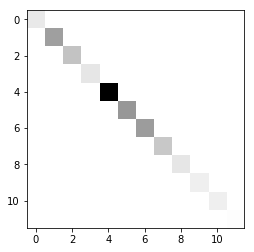

In [18]:
conf = confusion_matrix(test_y, predictions)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

While sklearn.metrics.confusion_matrix provides a numeric matrix, it can be more useful to generate a 'report' using the following (https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix)

In [19]:
pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,6,7,8,9,10,11,12,All
True,,,,,,,,,,,,,
1,16803,0,0,0,0,0,0,0,0,0,0,0,16803
2,0,70800,0,0,0,0,0,0,0,0,0,0,70800
3,0,0,43765,0,0,0,0,0,0,0,0,0,43765
4,0,0,2,18592,0,0,0,0,0,0,0,0,18594
5,0,0,0,0,188365,0,0,0,0,0,0,0,188365
6,0,0,0,0,0,77113,0,0,0,0,0,0,77113
7,0,0,0,0,0,0,72852,0,0,0,0,0,72852
8,0,0,0,0,0,0,0,40510,0,0,0,0,40510
9,0,0,0,0,0,0,0,0,18776,0,0,0,18776


In [20]:
test_score = r2_score(test_y, predictions)
spearman = spearmanr(test_y, predictions)
pearson = pearsonr(test_y, predictions)
print('Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print('Test data R-2 score: {test_score:>5.3}')
print('Test data Spearman correlation: {spearman[0]:.3}')
print('Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}
Test data R-2 score: {test_score:>5.3}
Test data Spearman correlation: {spearman[0]:.3}
Test data Pearson correlation: {pearson[0]:.3}


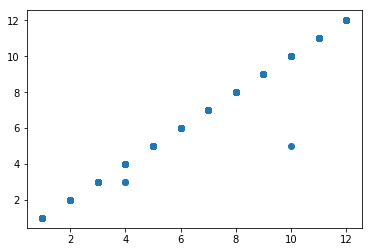

In [21]:
plt.scatter(test_y, predictions)
plt.show()

## How to inspect the importance of every feature in a random forest
With random forests we can get how important each feature was in classifying. In this case, we can clearly see that genetic association was more important in classification than RNA differential expression.

In [22]:
# inspect the importance of every feature in a random forest. 
headers = ["name", "score"]
values = sorted(zip(train_x.columns, trained_model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                        score
genetic_association   0.807504
animal_model          0.0796926
rna_expression        0.0344086
somatic_mutation      0.0273924
encoded_target_class  0.0225849
affected_pathway      0.0194254
literature            0.00683447
expression_score      0.0021524
encoded_locus_group   5.70974e-06
